In [1]:
#from google.colab import files
#uploaded = files.upload()

Saving project_tests.py to project_tests.py
Saving helper.py to helper.py


In [2]:
#!pip install tqdm
#!ls

datalab  helper.py  project_tests.py


In [4]:
#!pip install tqdm

    100% |████████████████████████████████| 51kB 5.0MB/s 


In [0]:
# %load main.py
#!/usr/bin/env python3
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import glob

In [7]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0-rc2
Default GPU Device: /device:GPU:0


In [8]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    model = tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    
    graph = tf.get_default_graph()
    
    w1 = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return w1, keep_prob, layer3_out, layer4_out, layer7_out
tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [9]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    
    
    # TODO: Implement function
    # Thanks to Subodh Malgode for the gradient tip (Slack) 
    
    # Freezing the gradients 
    
    vgg_layer7_out = tf.stop_gradient(vgg_layer7_out)
    
    vgg_layer4_out = tf.stop_gradient(vgg_layer4_out)
    
    vgg_layer3_out = tf.stop_gradient(vgg_layer3_out)
    
    #---------------------------------------------------------------------------------------------------------    
    layer7_conv = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, padding='same',
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                               kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    #upsample
    layer7_deconv = tf.layers.conv2d_transpose(layer7_conv, num_classes, 4, strides=(2,2) , padding='same', 
                                               kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                           kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    
    
    #---------------------------------------------------------------------------------------------------------
    layer4_conv = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, padding='same',
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                               kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    #skip connection
    skip_layer4 = tf.add(layer7_deconv, layer4_conv)
    #upsample
    layer4_deconv = tf.layers.conv2d_transpose(skip_layer4, num_classes, 4, strides=(2,2), padding='same', 
                                                kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                           kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    
    #---------------------------------------------------------------------------------------------------------
    layer3_conv = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, padding='same',
                                    kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                               kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    #skip connection
    skip_layer3 = tf.add(layer4_deconv, layer3_conv)
    #upsample
    nn_last_layer = tf.layers.conv2d_transpose(skip_layer3, num_classes, 16, strides=(8,8), padding='same', 
                                                kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                           kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    
    return nn_last_layer
tests.test_layers(layers)

Tests Passed


In [10]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    
    #output tensor is 4D so we have to reshape it to 2D, where each row represents a pixel and each column a class
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    labels = tf.reshape(correct_label, (-1, num_classes))
    
    #loss function
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    loss = tf.reduce_mean(cross_entropy_loss)

    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return logits, train_op, cross_entropy_loss
tests.test_optimize(optimize)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Tests Passed


In [0]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
      print("EPOCH {} ...".format(epoch+1))
      
      for image, label in get_batches_fn(batch_size):
        _, loss = sess.run([train_op, cross_entropy_loss],
                           feed_dict={input_image: image, correct_label: label,
                                      keep_prob: 0.5, learning_rate: 0.0001})
        print("Loss: = {:.2f}".format(loss))
      print()
    
    
tests.test_train_nn(train_nn)

In [0]:
#!wget  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip

In [0]:
#!unzip data_road.zip

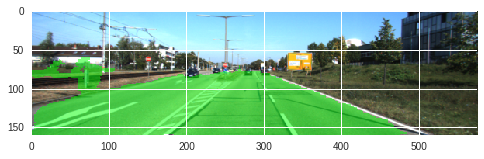

In [47]:
plt.imshow(x)

In [0]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = ''
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # TODO: Build NN using load_vgg, layers, and optimize function
        epochs = 50
        batch_size = 5
        
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes], name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')

        input_image, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)

        layer_output = layers(layer3_out, layer4_out, layer7_out, num_classes)

        logits, train_op, cross_entropy_loss = optimize(layer_output, correct_label, learning_rate, num_classes)

        # TODO: Train NN using the train_nn function
        train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate)

        # TODO: Save inference data using helper.save_inference_samples
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video


In [15]:
run()

997MB [01:12, 13.7MB/s]                           
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


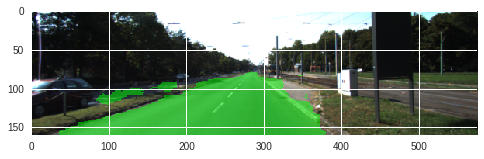

In [18]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('runs/1531071657.5536656/um_000000.png'))

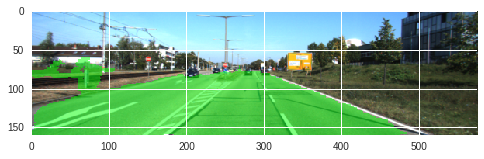

In [41]:
for filename in glob.glob('runs/1531071657.5536656/*.png'):
  x = (plt.imread(filename))
  print(plt.imshow(x))


In [0]:
#!zip -r filename1.zip runs/ 

In [0]:
#!ls

In [0]:
#files.download('filename.zip')

In [0]:
#import glob
#for filename in glob.glob('runs/1531071657.5536656/*.png'):
#  files.download(filename)

In [0]:
#files.download('filename1.zip')

In [0]:
#import cv2
#import os

#image_folder = 'runs/1531071657.5536656/'
#video_name = 'video.mp4'

#images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
#frame = cv2.imread(os.path.join(image_folder, images[0]))
#height, width, layers = frame.shape

#video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), 1, (width,height))

#for image in images:
#    video.write(cv2.imread(os.path.join(image_folder, image)))

#cv2.destroyAllWindows()
#video.release()

In [0]:
#files.download(video_name)